### Downloading Necessary Libraries

In [1]:
!pip install trimesh open3d plotly numpy

## Task 1: Load and Inspect the Mesh (20 Marks)

In [3]:
import trimesh
from glob import glob

# mapping from obj to mesh
meshes = {}
for path in glob("8samples/*"):
    mesh = trimesh.load(path)
    meshes[path.split('/')[1]] = mesh
meshes

{'branch.obj': <trimesh.Trimesh(vertices.shape=(2767, 3), faces.shape=(1960, 3))>,
 'cylinder.obj': <trimesh.Trimesh(vertices.shape=(192, 3), faces.shape=(124, 3))>,
 'explosive.obj': <trimesh.Trimesh(vertices.shape=(2812, 3), faces.shape=(2566, 3))>,
 'fence.obj': <trimesh.Trimesh(vertices.shape=(1088, 3), faces.shape=(684, 3))>,
 'girl.obj': <trimesh.Trimesh(vertices.shape=(8284, 3), faces.shape=(8475, 3))>,
 'person.obj': <trimesh.Trimesh(vertices.shape=(3103, 3), faces.shape=(2251, 3))>,
 'table.obj': <trimesh.Trimesh(vertices.shape=(3148, 3), faces.shape=(4100, 3))>,
 'talwar.obj': <trimesh.Trimesh(vertices.shape=(1668, 3), faces.shape=(1922, 3))>}

In [4]:
vertices_map = {}
faces_map = {}
for obj, mesh in list(meshes.items()):
    print(f"\n", "="*10, obj, "="*10)

    # Extract mesh components as numpy array
    verts = mesh.vertices
    faces = mesh.faces
    vertex_normals = mesh.vertex_normals
    uv_mappings = mesh.visual.uv
    
    vertices_map[obj] = verts
    faces_map[obj] = faces
    # Print shapes
    print("\n--- Basic Shapes ---")
    print(f"Vertices (v):        {verts.shape}")
    print(f"Faces (f):           {faces.shape}")
    print(f"Normals (vn):        {vertex_normals.shape}")
    print(f"Texture coords (vt): {uv_mappings.shape}")

    # Compute stats
    num_vertices = verts.shape[0]
    mins = verts.min(axis=0)
    maxs = verts.max(axis=0)
    means = verts.mean(axis=0)
    stds = verts.std(axis=0)

    # Pretty printing of statistics
    print("\n--- Vertex Statistics ---")
    print(f"Number of vertices: {num_vertices}")
    print(f"Min (x, y, z): [{mins[0]: .6f}, {mins[1]: .6f}, {mins[2]: .6f}]")
    print(f"Max (x, y, z): [{maxs[0]: .6f}, {maxs[1]: .6f}, {maxs[2]: .6f}]")
    print(f"Mean (x, y, z): [{means[0]: .6f}, {means[1]: .6f}, {means[2]: .6f}]")
    print(f"Std  (x, y, z): [{stds[0]: .6f}, {stds[1]: .6f}, {stds[2]: .6f}]")


 ========== branch.obj ==========

--- Basic Shapes ---
Vertices (v):        (2767, 3)
Faces (f):           (1960, 3)
Normals (vn):        (2767, 3)
Texture coords (vt): (2767, 2)

--- Vertex Statistics ---
Number of vertices: 2767
Min (x, y, z): [-0.851562,  0.000000, -0.464844]
Max (x, y, z): [ 0.849609,  1.900391,  0.462891]
Mean (x, y, z): [ 0.075443,  1.087390,  0.121967]
Std  (x, y, z): [ 0.343380,  0.456991,  0.200067]

 ========== cylinder.obj ==========

--- Basic Shapes ---
Vertices (v):        (192, 3)
Faces (f):           (124, 3)
Normals (vn):        (192, 3)
Texture coords (vt): (192, 2)

--- Vertex Statistics ---
Number of vertices: 192
Min (x, y, z): [-1.000000, -1.000000, -1.000000]
Max (x, y, z): [ 1.000000,  1.000000,  1.000000]
Mean (x, y, z): [-0.000000,  0.000000,  0.000000]
Std  (x, y, z): [ 0.707107,  1.000000,  0.707107]

 ========== explosive.obj ==========

--- Basic Shapes ---
Vertices (v):        (2812, 3)
Faces (f):           (2566, 3)
Normals (vn):      

### Visualizations

In [5]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

def compute_aspect_ratio(vertices):
    mins = vertices.min(axis=0)
    maxs = vertices.max(axis=0)
    scale = maxs - mins
    return dict(x=float(scale[0]), y=float(scale[1]), z=float(scale[2]))

def show_multiple_meshes(vertices_map, faces_map):
    objs = list(vertices_map.keys())
    n = len(objs)

    cols = 3
    rows = (n + cols - 1) // cols

    fig = make_subplots(
        rows=rows,
        cols=cols,
        specs=[[{"type": "scene"} for _ in range(cols)] for _ in range(rows)],
        subplot_titles=objs
    )

    for idx, obj in enumerate(objs):
        v = vertices_map[obj]
        f = faces_map[obj]

        r = (idx // cols) + 1
        c = (idx % cols) + 1

        fig.add_trace(
            go.Mesh3d(
                x=v[:,0], y=v[:,1], z=v[:,2],
                i=f[:,0], j=f[:,1], k=f[:,2],
                color='lightblue', opacity=0.8
            ),
            row=r, col=c
        )

        # ------- FIX PROPORTION --------
        fig.update_scenes(
            aspectmode='data',
            row=r, col=c
        )

    fig.update_layout(height=800, width=1400)
    fig.show()

# Call this after loading all your meshes
show_multiple_meshes(vertices_map, faces_map)

### Task 2: Normalize and Quantize the Mesh (40 Marks)

In [6]:
import numpy as np

def min_max_normalize(vertices):
    v_min = vertices.min(axis=0)
    v_max = vertices.max(axis=0)
    normalized = (vertices - v_min) / (v_max - v_min)
    return normalized

def unit_sphere_normalize(vertices):
    centroid = vertices.mean(axis=0)
    centered = vertices - centroid
    max_dist = np.linalg.norm(centered, axis=1).max()
    normalized = centered / max_dist
    return normalized

def quantize(vertices, bins=1024):
    quantized = np.rint(vertices * (bins - 1)).astype(np.int32)
    return quantized

def quantize_unit_sphere(vertices, bins=1024):
    scaled = (vertices + 1) / 2     # [-1,1] → [0,1]
    return quantize(scaled, bins)

In [7]:
import os
import trimesh
import numpy as np
from pathlib import Path


os.makedirs("normalized", exist_ok=True)
os.makedirs("quantized", exist_ok=True)

for name, vertices in vertices_map.items():
    faces = faces_map[name]

    mesh_name = Path(name).stem

    # -------- Min–Max --------
    mm_norm = min_max_normalize(vertices)
    mm_quant = quantize(mm_norm)

    # Save normalized
    mm_norm_mesh = trimesh.Trimesh(vertices=mm_norm, faces=faces, process=False)
    mm_norm_mesh.export(f"normalized/{mesh_name}_minmax_normal.obj")

    # Save quantized
    mm_quant_mesh = trimesh.Trimesh(vertices=mm_quant, faces=faces, process=False)
    mm_quant_mesh.export(f"quantized/{mesh_name}_minmax_quantized.obj")

    # -------- Unit Sphere --------
    us_norm = unit_sphere_normalize(vertices)
    us_quant = quantize_unit_sphere(us_norm)

    # Save normalized
    us_norm_mesh = trimesh.Trimesh(vertices=us_norm, faces=faces, process=False)
    us_norm_mesh.export(f"normalized/{mesh_name}_unit_sphere_normal.obj")

    # Save quantized
    us_quant_mesh = trimesh.Trimesh(vertices=us_quant, faces=faces, process=False)
    us_quant_mesh.export(f"quantized/{mesh_name}_unit_sphere_quantized.obj")

    print(f"Saved all versions for: {mesh_name}")

Saved all versions for: branch
Saved all versions for: cylinder
Saved all versions for: explosive
Saved all versions for: fence
Saved all versions for: girl
Saved all versions for: person
Saved all versions for: table
Saved all versions for: talwar


In [20]:
import os
import trimesh
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def compare_plots(name, method):
    # --- Load all 3 meshes ---
    paths = {
        "Original": os.path.join("8samples", f"{name}.obj"),
        "Normalized": os.path.join("normalized", f"{name}_{method}_normal.obj"),
        "Quantized": os.path.join("quantized", f"{name}_{method}_quantized.obj"),
    }

    meshes = {key: trimesh.load(path, process=False) for key, path in paths.items()}

    # --- Plot ---
    fig = make_subplots(
        rows=1, cols=3,
        specs=[[{"type": "scene"}] * 3],
        subplot_titles=list(paths.keys())
    )

    colors = ["blue", "red", "green"]

    for i, (label, mesh) in enumerate(meshes.items(), start=1):
        fig.add_trace(
            go.Mesh3d(
                x=mesh.vertices[:, 0],
                y=mesh.vertices[:, 1],
                z=mesh.vertices[:, 2],
                i=mesh.faces[:, 0],
                j=mesh.faces[:, 1],
                k=mesh.faces[:, 2],
                color=colors[i - 1],
                opacity=0.5,
                name=label
            ),
            row=1, col=i
        )

    fig.update_layout(
        height=600,
        width=1400,
        title_text=f"Mesh Visualization: {name} ({method} normalization)"
    )
    fig.show()

compare_plots("branch", "minmax")

In [9]:
compare_plots("branch", "unit_sphere")

## Task 3: Dequantize, Denormalize, and Measure Error (40 Marks)

In [14]:
import os
import numpy as np
import trimesh

def mse(a, b):
    return np.mean((a - b) ** 2)

def mse_axis(a, b):
    return np.mean((a - b) ** 2, axis=0)

def reconstruct_minmax(q_vertices, v_min, v_max, bins=1024):
    """Dequantize → Denormalize (Min-Max)"""
    norm = q_vertices / (bins - 1)
    return norm * (v_max - v_min) + v_min


def reconstruct_unitsphere(q_vertices, centroid, max_dist, bins=1024):
    """Dequantize → Move from [0,1]→[-1,1] → Denormalize"""
    scaled = q_vertices / (bins - 1)
    norm = scaled * 2 - 1
    return norm * max_dist + centroid


def evaluate_reconstruction(name, method, bins=1024):
    # FILE PATHS
    paths = {
        "original":  os.path.join("8samples", f"{name}.obj"),
        "normalized": os.path.join("normalized", f"{name}_{method}_normal.obj"),
        "quantized": os.path.join("quantized", f"{name}_{method}_quantized.obj"),
    }

    # LOAD MESHES
    meshes = {key: trimesh.load(p, process=False) for key, p in paths.items()}

    orig = meshes["original"].vertices
    quant = meshes["quantized"].vertices
    faces = meshes["original"].faces
    
    if method == "minmax":

        # Need original min/max to denormalize
        v_min = orig.min(axis=0)
        v_max = orig.max(axis=0)

        rec = reconstruct_minmax(quant, v_min, v_max, bins)

    elif method == "unit_sphere":

        centroid = orig.mean(axis=0)
        max_dist = np.linalg.norm(orig - centroid, axis=1).max()

        rec = reconstruct_unitsphere(quant, centroid, max_dist, bins)

    else:
        raise ValueError("method must be 'minmax' or 'unit_sphere'")

    total_err = mse(orig, rec)
    axis_err = mse_axis(orig, rec)

    os.makedirs("reconstructed",exist_ok=True)

    # Save quantized
    rec_mesh = trimesh.Trimesh(vertices=rec, faces=faces, process=False)
    rec_mesh.export(f"reconstructed/{name}_{method}_reconstructed.obj")
    
    return {
        "method": method,
        "total_mse": total_err,
        "axis_mse": axis_err,
        "reconstructed_vertices": rec
    }

In [15]:
min_max = evaluate_reconstruction("branch","minmax")
unit_sph = evaluate_reconstruction("branch","unit_sphere")

In [19]:
import os
import trimesh
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def compare_plots(name, method):
    # --- Load all 3 meshes ---
    paths = {
        "Original": os.path.join("8samples", f"{name}.obj"),
        "Reconstructed": os.path.join("reconstructed", f"{name}_{method}_reconstructed.obj")
    }

    meshes = {key: trimesh.load(path, process=False) for key, path in paths.items()}

    # --- Plot ---
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{"type": "scene"}] * 2],
        subplot_titles=list(paths.keys())
    )

    colors = ["blue", "red"]

    for i, (label, mesh) in enumerate(meshes.items(), start=1):
        fig.add_trace(
            go.Mesh3d(
                x=mesh.vertices[:, 0],
                y=mesh.vertices[:, 1],
                z=mesh.vertices[:, 2],
                i=mesh.faces[:, 0],
                j=mesh.faces[:, 1],
                k=mesh.faces[:, 2],
                color=colors[i - 1],
                opacity=0.5,
                name=label
            ),
            row=1, col=i
        )

    fig.update_layout(
        height=600,
        width=1400,
        title_text=f"Mesh Visualization: {name} ({method} normalization)"
    )
    fig.show()

compare_plots("branch", "minmax")

In [17]:
compare_plots("branch", "unit_sphere")

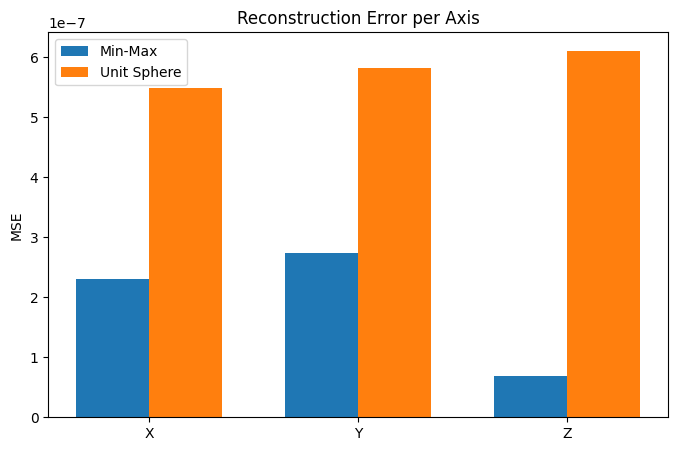

In [18]:
import matplotlib.pyplot as plt
import numpy as np

axis_labels = ["X", "Y", "Z"]
x = np.arange(3)

width = 0.35

mm_axis = min_max['axis_mse']
us_axis = unit_sph['axis_mse']


plt.figure(figsize=(8, 5))
plt.bar(x - width/2, mm_axis, width, label="Min-Max")
plt.bar(x + width/2, us_axis, width, label="Unit Sphere")

plt.xticks(x, axis_labels)
plt.ylabel("MSE")
plt.title("Reconstruction Error per Axis")
plt.legend()
plt.show()